In [1]:
from RCalib import *
import torch
from torch.utils.data import DataLoader
from torch import optim
import argparse

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
modelrnn = RCalibNet()

In [3]:
root_folder = './script/dataset_512'
modelrnn.load_state_dict(torch.load('./rcalib-nuscenes-2.ckpt'))
nuset = NuscenesDatset(root_folder, "train", seq_len = 6)
train_dataloader = DataLoader(nuset, batch_size=8, shuffle=True, num_workers=8)

In [4]:
it = iter(train_dataloader)
data_batch = next(it)

In [13]:
modelrnn.cuda()
modelrnn.train()
optimizer = optim.Adam(modelrnn.parameters(), lr=0.0001)
loss_list = []
# data_batch = next(it)
for epoch in range(1):
    for data_batch in train_dataloader:
        
        for key in data_batch.keys():            
            data_batch[key] = data_batch[key].cuda()
            
          
        B, S, C, H, W = data_batch['depth'].shape
        modelrnn.zero_grad()
        modelrnn.reset_hidden(B)
        def transform_depth(depth_map, extrinsic):    
            y = torch.arange(H)
            x = torch.arange(W)
            gridy, gridx = torch.meshgrid(x, y, indexing='ij')
            # mask_batch = (data_batch['depth'] < 0.1)
            gridx_batch = gridx.unsqueeze(0).unsqueeze(0).repeat([B,C,1,1]).cuda()
            gridy_batch = gridy.unsqueeze(0).unsqueeze(0).repeat([B,C,1,1]).cuda()

            # mask = (data_batch['depth'][0,0] == 0)[0]
            uvz = torch.zeros((B,3,H,W), dtype=torch.float32).cuda()
            uvz[:,0] = (gridx_batch * depth_map)[:,0]
            uvz[:,1] = (gridy_batch * depth_map)[:,0]
            uvz[:,2] = (depth_map)[:,0]
            points3d = (torch.inverse(data_batch['intrinsic'][:,frame_id]) @ uvz.reshape(B,3,-1))
            points3d_hom = torch.cat((points3d, torch.ones(B, 1, points3d.shape[-1]).cuda()),dim=1)
            projected = data_batch['intrinsic'][:,frame_id] @ (extrinsic @ points3d_hom)[:,:3]
            Z = projected[:,2,:]
            Y = projected[:,1,:] / Z
            X = projected[:,0,:] / Z
            X = X.to(torch.int64); Y = Y.to(torch.int64)
            depth_out = torch.zeros(B, C, H, W).cuda()
            flag = (Y < W) & (Y > 0) & (X > 0) & (X < W)
            flag_out_mean = torch.zeros(1).cuda()
            # for b in range(B):
            for b in range(B):
                flag_idx = flag[b]
                depth_out[b,:, Y[b, flag_idx],X[b, flag_idx]] = Z[b, flag_idx]
            return depth_out
        loss = torch.zeros(1).cuda()
        loss_squence_list = []
        for frame_id in range(S):
            # frame_id = 0 # 
            if frame_id == 0:        
                extrinsic_chained = torch.eye(4).unsqueeze(0).repeat(B,1,1).cuda()
                depth_ts = data_batch['depth'][:,frame_id]
                pose_gt = data_batch['pose'][:,frame_id].view(B,6)
                pose_org = data_batch['pose'][:,frame_id].view(B,6)
            else:
                # print(frame_id)
                pose_gt = matrix_to_rtvec(rtvec_to_matrix(data_batch['pose'][:,frame_id].view(B,6)) @ torch.inverse(extrinsic_chained))
                depth_ts = data_batch['depth'][:,frame_id]
                depth_ts = transform_depth(depth_ts, extrinsic_chained)
                # depth_ts = depth_out


            calib_out = modelrnn(data_batch['img'][:,frame_id], depth_ts[:,:,50:-50,50:-50])
            calib_out_tanh = torch.tanh(calib_out)
            # extrinsic_ts = rtvec_to_matrix(calib_out_tanh * torch.pi).view(B,4,4)
            extrinsic_ts = rtvec_to_matrix(calib_out_tanh * torch.pi).view(B,4,4)        
            depth_out = transform_depth(depth_ts, extrinsic_ts)    
            extrinsic_chained = extrinsic_ts.detach() @ extrinsic_chained

            # loss_linear = (data_batch['pose'][:,frame_id].view(B,6)/torch.pi - calib_out_tanh).abs().mean()
            loss_linear = (pose_gt/torch.pi - calib_out_tanh).abs().mean()
            loss_depth = (data_batch['depth_gt'][:,frame_id] - depth_out).abs().mean()
            loss_squence_list.append(loss_linear.detach().cpu().numpy())
            loss += loss_depth/250 + loss_linear

            # if frame_id == 3:
            #     break
        loss.backward()
        optimizer.step()
        loss_list.append(loss.detach().cpu().numpy())
        print(f'Squence {loss_squence_list} loss : {loss}, linear : {loss_linear}, depth : {loss_depth} ', end='\r')    
        break
    # extrinsic_predict_np = np.append(extrinsic_predict_np, (calib_out_tanh*torch.pi).detach().cpu().numpy(), axis=0)
    # extrinsic_gt_np = np.append(extrinsic_gt_np, (data_batch['pose'].view(B,6)).detach().cpu().numpy(), axis=0)


In [14]:
depth_ts

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

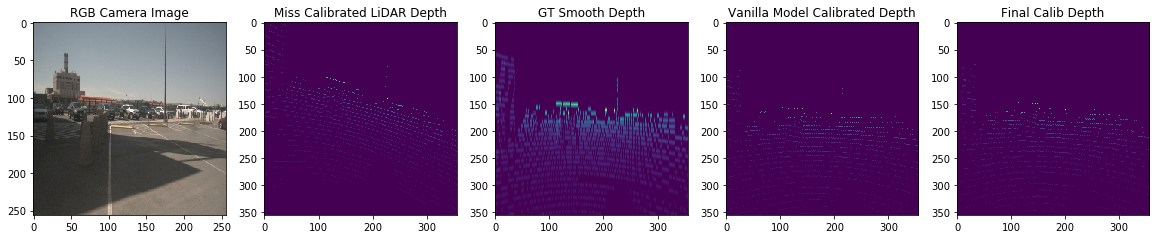

In [15]:
batch_id = 0
plt.figure(figsize=[20,20])
plt.subplot(151)
plt.title('RGB Camera Image')
plt.imshow(np.transpose(data_batch['img'][batch_id,-1].cpu().numpy(), axes=(1,2,0))[..., ::-1])
plt.subplot(152)
plt.title('Miss Calibrated LiDAR Depth')
plt.imshow(data_batch['depth'][batch_id,-1,0].cpu().numpy())
plt.subplot(153)
plt.title('GT Smooth Depth')
plt.imshow(data_batch['depth_gt'][batch_id,-1,0].cpu().numpy())
plt.subplot(154)
plt.title('Vanilla Model Calibrated Depth')
plt.imshow(depth_out[batch_id,0].detach().cpu().numpy())
depth_gt_final = transform_depth(depth_out, rtvec_to_matrix(pose_gt))
plt.subplot(155)
plt.title('Final Calib Depth')
plt.imshow(depth_gt_final[batch_id,0].detach().cpu().numpy())